In [1]:
# !pip install lightgbm
# !pip install optuna

In [35]:
import sqlite3
import pandas as pd
import numpy as np

from datetime import datetime
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.inspection import permutation_importance
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import matplotlib.pyplot as plt 
import seaborn as sns # Import seaborn

from datetime import date
from dateutil import parser

import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import optuna
from optuna.integration import OptunaSearchCV

from collections import defaultdict

import time

from warnings import simplefilter

In [3]:
simplefilter(action="ignore",category=FutureWarning)

In [4]:
pd.options.mode.chained_assignment = None

# Import pre-processed data frame
curr_date = "2023-04-22"
pickle_file = 'sa-preprocessing-' + curr_date + '.pkl'
pickle_file_path = 'data/' + pickle_file
df_main_nn = pd.read_pickle(pickle_file_path)

df_main_nn.head

<bound method NDFrame.head of        id_main     season       date  match_api_id  home_team_api_id  \
6559     17130  2013/2014 2013-08-30       1467856              1601   
9336     17146  2013/2014 2013-09-22       1467891              1601   
20967    16930  2013/2014 2013-09-28       1467712              1601   
21295    17020  2013/2014 2013-12-07       1468015              1601   
395      17039  2013/2014 2014-02-16       1467719              1601   
...        ...        ...        ...           ...               ...   
2869      1589  2015/2016 2015-12-19       1979980            274581   
321       1549  2015/2016 2015-12-22       1979948            274581   
5596      1613  2015/2016 2016-01-23       1980004            274581   
6049      1629  2015/2016 2016-02-06       1980020            274581   
12375     1661  2015/2016 2016-03-05       1980052            274581   

       away_team_api_id  home_team_goal  away_team_goal  home_player_1  \
6559               8021        

In [5]:
# Create the dataframe for modeling
# feature_names = ["last_ten","last_five","last_three",
#                  "away_player_height_average","away_player_height_average",
# #                  "home_player_weight_average",
# #               "away_player_weight_average",
# #                  'home_player_age_average','away_player_age_average',
#                  'home_player_rating_average','away_player_rating_average',
#               'home_team_bmi' ,'away_team_bmi', 
#                  'last_10_diff']
feature_names = ["last_ten","last_five","last_three",  'last_10_diff', 
                "avg_height_diff", "avg_weight_diff", "avg_rating_diff",
                "avg_age_diff", "avg_bmi_diff"]
X = df_main_nn[feature_names].values
y = df_main_nn['outcome'].values

In [6]:
scaler = preprocessing.MinMaxScaler().fit(X)
X = scaler.transform(X)

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y)
pd.DataFrame(X).tail(100)

,0,1,2,3,4,5,6,7,8
20082,0.3,0.2,0.333333,0.285714,0.406593,0.415323,0.430412,0.565714,0.441696
20083,0.3,0.2,0.000000,0.285714,0.241758,0.338710,0.311856,0.525714,0.525802
20084,0.3,0.2,0.000000,0.317460,0.329670,0.350806,0.420103,0.371429,0.444448
20085,0.2,0.0,0.000000,0.285714,0.461538,0.364919,0.445876,0.582857,0.318689
20086,0.3,0.2,0.333333,0.333333,0.351648,0.231855,0.422680,0.445714,0.272671
...,...,...,...,...,...,...,...,...,...
20177,0.2,0.0,0.000000,0.301587,0.472527,0.439516,0.512887,0.537143,0.404196
20178,0.1,0.0,0.000000,0.269841,0.483516,0.570565,0.402062,0.297143,0.553104
20179,0.1,0.0,0.000000,0.285714,0.340659,0.356855,0.384021,0.365714,0.443024
20180,0.1,0.0,0.000000,0.285714,0.538462,0.548387,0.347938,0.531429,0.468341


In [8]:
df_main_nn[feature_names].tail(100)

,last_ten,last_five,last_three,last_10_diff,avg_height_diff,avg_weight_diff,avg_rating_diff,avg_age_diff,avg_bmi_diff
15630,3.0,1.0,1.0,-4,-1.154545,-3.272727,-1.181818,1.545455,-0.166628
18436,3.0,1.0,0.0,-4,-4.618182,-6.727273,-5.363636,0.909091,0.257881
12188,3.0,1.0,0.0,-2,-2.770909,-6.181818,-1.545455,-1.545455,-0.152738
14812,2.0,0.0,0.0,-4,0.000000,-5.545455,-0.636364,1.818182,-0.787480
15249,3.0,1.0,1.0,-1,-2.309091,-11.545455,-1.454545,-0.363636,-1.019745
...,...,...,...,...,...,...,...,...,...
2869,2.0,0.0,0.0,-3,0.230909,-2.181818,1.727273,1.090909,-0.355899
321,1.0,0.0,0.0,-5,0.461818,3.727273,-2.181818,-2.727273,0.395681
5596,1.0,0.0,0.0,-4,-2.540000,-5.909091,-2.818182,-1.636364,-0.159922
6049,1.0,0.0,0.0,-4,1.616364,2.727273,-4.090909,1.000000,-0.032142


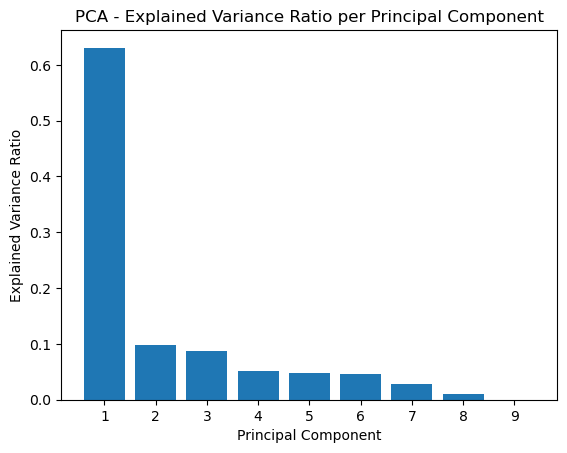

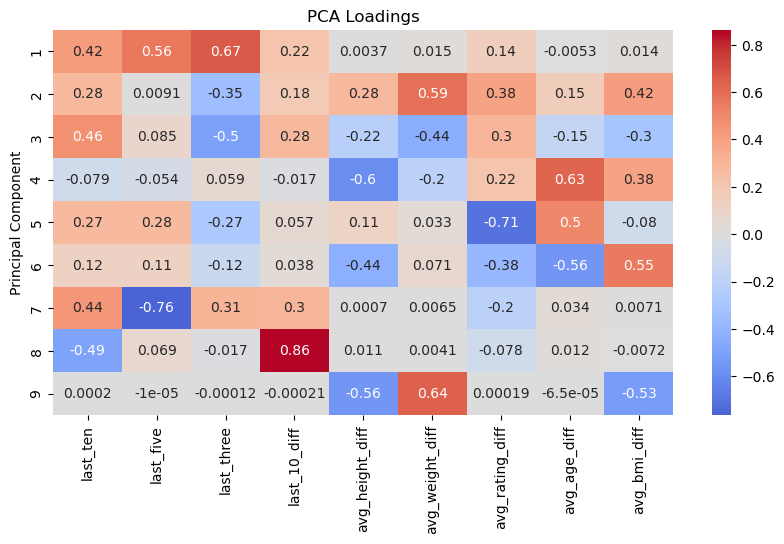

In [9]:
# Perform PCA on the scaled data
pca = PCA()
X_pca = pca.fit_transform(X)

# Determine the explained variance ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Create a bar chart to visualize the explained variance ratio
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA - Explained Variance Ratio per Principal Component')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.show()

# Extract the PCA loadings (components_)
loadings = pca.components_

# Create a DataFrame with the loadings and feature names
loadings_df = pd.DataFrame(loadings, columns=feature_names)
loadings_df.index.name = 'Principal Component'
loadings_df.index += 1

import seaborn as sns

plt.figure(figsize=(10, 5))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', center=0)
plt.title("PCA Loadings")
plt.show()


In [10]:
# Baseline models
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()

decision_tree.fit(X_train, y_train)
random_forest.fit(X_train, y_train)

print(decision_tree.score(X_test, y_test))
print(random_forest.score(X_test, y_test))

0.5552913198573127
0.6072136345620294


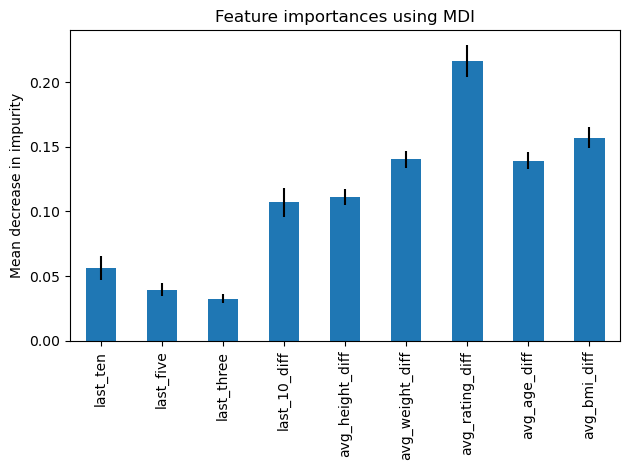

In [11]:
# Feature importance (RF) - based on mean decrease in impurity
importances = random_forest.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)

ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

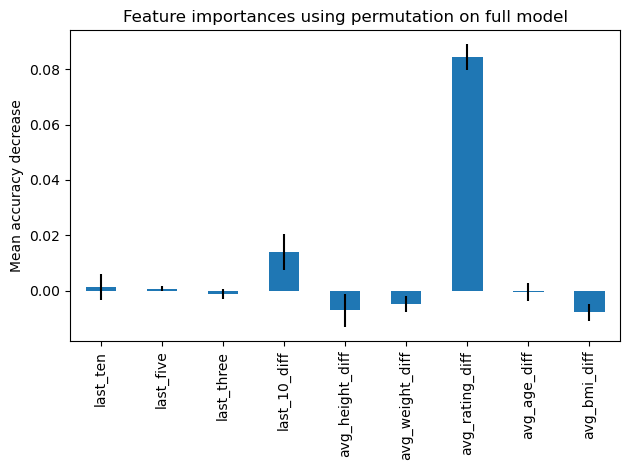

In [12]:

result = permutation_importance(
    random_forest, X_test, y_test) # n_repeats=10, random_state=42, n_jobs=2

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [13]:
from sklearn.inspection import permutation_importance

# Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 200)
    max_depth = trial.suggest_int("max_depth", 10, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   random_state=0)

    score = np.mean(cross_val_score(model, X_train, y_train, cv=5))
    return score

# Create a study object and run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Train the final model with the best hyperparameters
best_params = study.best_params
rf = RandomForestClassifier(**best_params)
rf.fit(X_train, y_train)

# Calculate permutation importance
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=0)

# Display the feature importances
importance_df = pd.DataFrame({'feature': feature_names, 'importance': result.importances_mean})
importance_df = importance_df.sort_values('importance', ascending=False)
print(importance_df)

[I 2023-04-22 16:16:42,755] A new study created in memory with name: no-name-af8c4ae9-9675-4755-9be9-0453ce6f17b9
[I 2023-04-22 16:16:48,279] Trial 0 finished with value: 0.638081441399924 and parameters: {'n_estimators': 133, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.638081441399924.
[I 2023-04-22 16:16:56,379] Trial 1 finished with value: 0.6267839335893297 and parameters: {'n_estimators': 147, 'max_depth': 38, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.638081441399924.
[I 2023-04-22 16:16:58,500] Trial 2 finished with value: 0.6259251937319738 and parameters: {'n_estimators': 39, 'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.638081441399924.
[I 2023-04-22 16:17:00,985] Trial 3 finished with value: 0.635240431885815 and parameters: {'n_estimators': 59, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.63

           feature  importance
6  avg_rating_diff    0.092251
3     last_10_diff    0.004102
2       last_three    0.000773
7     avg_age_diff   -0.000872
1        last_five   -0.002200
0         last_ten   -0.002735
4  avg_height_diff   -0.003092
8     avg_bmi_diff   -0.003508
5  avg_weight_diff   -0.003646


In [14]:
test_accuracy = rf.score(X_test, y_test)

print('Best accuracy:', study.best_value)
print('Best parameters:', study.best_params)
print('Accuracy on test data:', test_accuracy)

Best accuracy: 0.638081441399924
Best parameters: {'n_estimators': 133, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 10}
Accuracy on test data: 0.6270313119302418


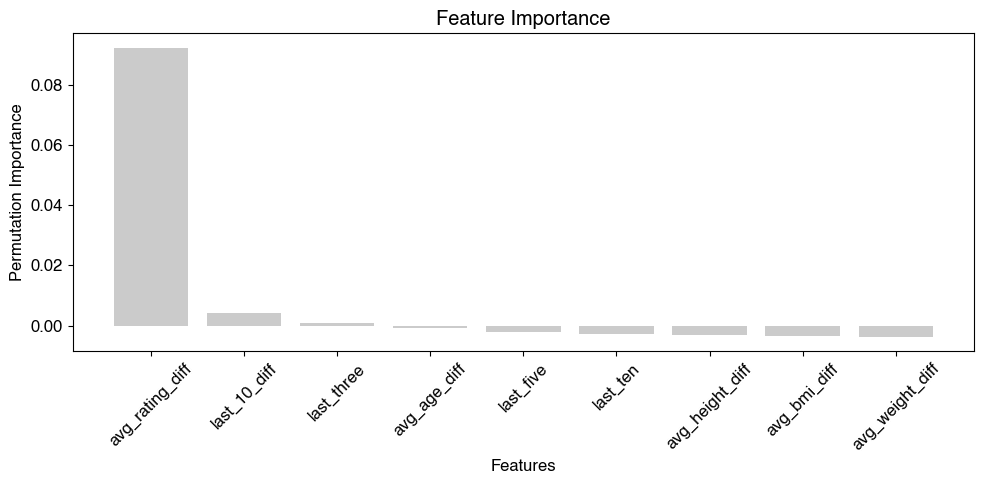

In [15]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set the font to Helvetica with size 12
rcParams['font.family'] = 'Helvetica'
rcParams['font.size'] = 12

# Plot the feature importances in a bar graph
plt.figure(figsize=(10, 5))
plt.bar(importance_df['feature'], importance_df['importance'], color='#CBCBCB')
plt.xlabel('Features')
plt.ylabel('Permutation Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('data/feature_importance.pdf')
plt.show()


In [16]:
def objective(trial):
    params = {
        'C': trial.suggest_loguniform('C', 1e-5, 1e2),
        'solver': trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'random_state': 42
    }

    model = LogisticRegression(**params)
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    mean_accuracy = scores.mean()

    return mean_accuracy

In [17]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
logistic_regression = LogisticRegression(**best_params)
logistic_regression.fit(X_train, y_train)

test_accuracy = logistic_regression.score(X_test, y_test)

print('Best accuracy:', study.best_value)
print('Best parameters:', study.best_params)
print('Accuracy on test data:', test_accuracy)


[I 2023-04-22 16:17:45,464] A new study created in memory with name: no-name-141e65e5-b5ba-4872-b751-afa0e21411ed
[I 2023-04-22 16:17:45,693] Trial 0 finished with value: 0.6397976235898305 and parameters: {'C': 0.041479840624030505, 'solver': 'sag', 'max_iter': 709}. Best is trial 0 with value: 0.6397976235898305.
C:\Users\richt\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\richt\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\richt\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\richt\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did n

[I 2023-04-22 16:18:00,774] Trial 32 finished with value: 0.6397315297365589 and parameters: {'C': 0.056441691173131164, 'solver': 'newton-cg', 'max_iter': 621}. Best is trial 13 with value: 0.6400618680375538.
[I 2023-04-22 16:18:01,074] Trial 33 finished with value: 0.631472242764382 and parameters: {'C': 0.012890403288342586, 'solver': 'newton-cg', 'max_iter': 514}. Best is trial 13 with value: 0.6400618680375538.
[I 2023-04-22 16:18:01,401] Trial 34 finished with value: 0.6383434715076122 and parameters: {'C': 0.18266400818267706, 'solver': 'saga', 'max_iter': 820}. Best is trial 13 with value: 0.6400618680375538.
[I 2023-04-22 16:18:01,763] Trial 35 finished with value: 0.638408910534068 and parameters: {'C': 0.552580379495559, 'solver': 'newton-cg', 'max_iter': 933}. Best is trial 13 with value: 0.6400618680375538.
[I 2023-04-22 16:18:02,169] Trial 36 finished with value: 0.6377482775871989 and parameters: {'C': 1.0014661731366412, 'solver': 'sag', 'max_iter': 725}. Best is trial

Best accuracy: 0.6401934882275235
Best parameters: {'C': 0.05952393266065747, 'solver': 'liblinear', 'max_iter': 829}
Accuracy on test data: 0.6323820848196592


In [18]:
def objective_gnb(trial):
    params = {
        'var_smoothing': trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
    }

    model = GaussianNB(**params)
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    mean_accuracy = scores.mean()

    return mean_accuracy

In [19]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_gnb, n_trials=50)

best_params = study.best_params
gnb = GaussianNB(**best_params)
gnb.fit(X_train, y_train)

test_accuracy = gnb.score(X_test, y_test)

print('Best accuracy:', study.best_value)
print('Best parameters:', study.best_params)
print('Accuracy on test data:', test_accuracy)


[I 2023-04-22 16:18:05,487] A new study created in memory with name: no-name-2779cfed-7c07-43a4-8237-d92c417ae442
[I 2023-04-22 16:18:05,539] Trial 0 finished with value: 0.6192498129378063 and parameters: {'var_smoothing': 0.00018621773750366968}. Best is trial 0 with value: 0.6192498129378063.
[I 2023-04-22 16:18:05,587] Trial 1 finished with value: 0.6191837627396557 and parameters: {'var_smoothing': 4.6638069134958985e-09}. Best is trial 0 with value: 0.6192498129378063.
[I 2023-04-22 16:18:05,632] Trial 2 finished with value: 0.6191837627396557 and parameters: {'var_smoothing': 2.7855017230276375e-09}. Best is trial 0 with value: 0.6192498129378063.
[I 2023-04-22 16:18:05,679] Trial 3 finished with value: 0.6194479635322581 and parameters: {'var_smoothing': 0.001700904148017133}. Best is trial 3 with value: 0.6194479635322581.
[I 2023-04-22 16:18:05,717] Trial 4 finished with value: 0.6195140573855297 and parameters: {'var_smoothing': 0.00246680465874566}. Best is trial 4 with val

[I 2023-04-22 16:18:07,254] Trial 42 finished with value: 0.6193819133341075 and parameters: {'var_smoothing': 0.0015116436428844712}. Best is trial 25 with value: 0.6201748649528831.
[I 2023-04-22 16:18:07,294] Trial 43 finished with value: 0.6199765833930682 and parameters: {'var_smoothing': 0.00739753568408131}. Best is trial 25 with value: 0.6201748649528831.
[I 2023-04-22 16:18:07,332] Trial 44 finished with value: 0.6194482691181055 and parameters: {'var_smoothing': 0.0358331474634262}. Best is trial 25 with value: 0.6201748649528831.
[I 2023-04-22 16:18:07,372] Trial 45 finished with value: 0.6194479635322581 and parameters: {'var_smoothing': 0.0017262477739162397}. Best is trial 25 with value: 0.6201748649528831.
[I 2023-04-22 16:18:07,413] Trial 46 finished with value: 0.6193160814115621 and parameters: {'var_smoothing': 0.03815382217617259}. Best is trial 25 with value: 0.6201748649528831.
[I 2023-04-22 16:18:07,455] Trial 47 finished with value: 0.6199765833930682 and parame

Best accuracy: 0.6201748649528831
Best parameters: {'var_smoothing': 0.009752760872117967}
Accuracy on test data: 0.6175188267934998


In [20]:
from sklearn.neighbors import KNeighborsClassifier

def objective_knn(trial):
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 50),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'p': trial.suggest_int('p', 1, 5)
    }

    model = KNeighborsClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    mean_accuracy = scores.mean()

    return mean_accuracy


In [21]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_knn, n_trials=15)

best_params = study.best_params
k_neighbors = KNeighborsClassifier(**best_params)
k_neighbors.fit(X_train, y_train)

test_accuracy = k_neighbors.score(X_test, y_test)

print('Best accuracy:', study.best_value)
print('Best parameters:', study.best_params)
print('Accuracy on test data:', test_accuracy)


[I 2023-04-22 16:18:07,576] A new study created in memory with name: no-name-45a00a73-62bd-416e-b63f-053dff16898e
[I 2023-04-22 16:18:11,537] Trial 0 finished with value: 0.5955997737666155 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'p': 4}. Best is trial 0 with value: 0.5955997737666155.
[I 2023-04-22 16:18:12,473] Trial 1 finished with value: 0.6217626347461137 and parameters: {'n_neighbors': 44, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.6217626347461137.
[I 2023-04-22 16:18:18,899] Trial 2 finished with value: 0.6205735566166064 and parameters: {'n_neighbors': 47, 'weights': 'distance', 'p': 5}. Best is trial 1 with value: 0.6217626347461137.
[I 2023-04-22 16:18:24,131] Trial 3 finished with value: 0.6079545866156594 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'p': 3}. Best is trial 1 with value: 0.6217626347461137.
[I 2023-04-22 16:18:29,959] Trial 4 finished with value: 0.6176004903468956 and parameters: {'n_neighbors': 32, 'weights

Best accuracy: 0.6228197215810676
Best parameters: {'n_neighbors': 50, 'weights': 'uniform', 'p': 1}
Accuracy on test data: 0.6191042409829568


In [22]:
from sklearn.ensemble import AdaBoostClassifier

def objective_adaboost(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1)
    }

    model = AdaBoostClassifier(**params, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    mean_accuracy = scores.mean()

    return mean_accuracy


In [23]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_adaboost, n_trials=5)

best_params = study.best_params
ada_boost = AdaBoostClassifier(**best_params, random_state=42)
ada_boost.fit(X_train, y_train)

test_accuracy = ada_boost.score(X_test, y_test)

print('Best accuracy:', study.best_value)
print('Best parameters:', study.best_params)
print('Accuracy on test data:', test_accuracy)

[I 2023-04-22 16:18:47,860] A new study created in memory with name: no-name-747b36de-0a4b-431f-b7c4-b03b95541d0c
[I 2023-04-22 16:19:00,013] Trial 0 finished with value: 0.6372228542850148 and parameters: {'n_estimators': 421, 'learning_rate': 0.22082188190978647}. Best is trial 0 with value: 0.6372228542850148.
[I 2023-04-22 16:19:05,990] Trial 1 finished with value: 0.6372885117168732 and parameters: {'n_estimators': 209, 'learning_rate': 0.08410166143603699}. Best is trial 1 with value: 0.6372885117168732.
[I 2023-04-22 16:19:07,084] Trial 2 finished with value: 0.6325316973308039 and parameters: {'n_estimators': 38, 'learning_rate': 0.7270623982934007}. Best is trial 1 with value: 0.6372885117168732.
[I 2023-04-22 16:19:18,050] Trial 3 finished with value: 0.6362315994447157 and parameters: {'n_estimators': 385, 'learning_rate': 0.006686217369719448}. Best is trial 1 with value: 0.6372885117168732.
[I 2023-04-22 16:19:29,837] Trial 4 finished with value: 0.6331266291618498 and par

Best accuracy: 0.6372885117168732
Best parameters: {'n_estimators': 209, 'learning_rate': 0.08410166143603699}
Accuracy on test data: 0.633769322235434


In [24]:
def objective_gradient_boost(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20)
    }

    model = GradientBoostingClassifier(**params, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    mean_accuracy = scores.mean()

    return mean_accuracy


In [25]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_gradient_boost, n_trials=15)

best_params = study.best_params
gradient_boost = GradientBoostingClassifier(**best_params, random_state=42)
gradient_boost.fit(X_train, y_train)

test_accuracy = gradient_boost.score(X_test, y_test)

print('Best accuracy:', study.best_value)
print('Best parameters:', study.best_params)
print('Accuracy on test data:', test_accuracy)


[I 2023-04-22 16:19:31,394] A new study created in memory with name: no-name-5ccfbc17-9434-412f-ae46-9755082ba00b
[I 2023-04-22 16:20:10,973] Trial 0 finished with value: 0.6355048508819131 and parameters: {'n_estimators': 471, 'learning_rate': 0.011410643088786464, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.6355048508819131.
[I 2023-04-22 16:20:58,548] Trial 1 finished with value: 0.6188556186745535 and parameters: {'n_estimators': 262, 'learning_rate': 0.03169259926392849, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.6355048508819131.
[I 2023-04-22 16:21:47,061] Trial 2 finished with value: 0.6343815829267111 and parameters: {'n_estimators': 414, 'learning_rate': 0.00738278061269796, 'max_depth': 7, 'min_samples_split': 17, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.6355048508819131.
[I 2023-04-22 16:22:23,869] Trial 3 finished with value: 0.6376850747499716 and paramete

Best accuracy: 0.6398652113366318
Best parameters: {'n_estimators': 205, 'learning_rate': 0.016764197498531634, 'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 5}
Accuracy on test data: 0.6327784383670234


In [26]:
# Define the objective function
def objective(trial):
    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'random_state': 42
    }
    model = lgb.LGBMClassifier(**params)
    #model.fit(X_train, y_train)
    #y_pred = model.predict(X_test)
    #accuracy = accuracy_score(y_test, y_pred)
    # Use cross_val_score for cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    mean_accuracy = scores.mean()
    return mean_accuracy

In [27]:
# Define the search space using IntLogUniformDistribution
search_space = {
    'num_leaves': optuna.distributions.IntLogUniformDistribution(2, 256),
    'learning_rate': optuna.distributions.LogUniformDistribution(0.001, 0.1),
    'max_depth': optuna.distributions.IntUniformDistribution(3, 10),
    'feature_fraction': optuna.distributions.UniformDistribution(0.1, 1.0),
    'bagging_fraction': optuna.distributions.UniformDistribution(0.1, 1.0),
    'bagging_freq': optuna.distributions.IntUniformDistribution(1, 10),
    'min_child_samples': optuna.distributions.IntUniformDistribution(5, 100),
}

# Create a study object and run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2023-04-22 16:25:02,775] A new study created in memory with name: no-name-75f45734-2e27-4dae-85d2-380586b6d43f


[LightGBM] [Warning] feature_fraction is set=0.11077214003515051, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11077214003515051
[LightGBM] [Warning] bagging_fraction is set=0.8747355258498289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8747355258498289
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.11077214003515051, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11077214003515051
[LightGBM] [Warning] bagging_fraction is set=0.8747355258498289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8747355258498289
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.11077214003515051, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11077214003515051
[LightGBM] [Warning] b

[I 2023-04-22 16:25:03,516] Trial 0 finished with value: 0.6251981178639274 and parameters: {'num_leaves': 92, 'learning_rate': 0.08797576229606495, 'max_depth': 9, 'feature_fraction': 0.11077214003515051, 'bagging_fraction': 0.8747355258498289, 'bagging_freq': 3, 'min_child_samples': 87}. Best is trial 0 with value: 0.6251981178639274.


[LightGBM] [Warning] feature_fraction is set=0.11077214003515051, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11077214003515051
[LightGBM] [Warning] bagging_fraction is set=0.8747355258498289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8747355258498289
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.22347451297292548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22347451297292548
[LightGBM] [Warning] bagging_fraction is set=0.33537487426110413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.33537487426110413
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-22 16:25:03,789] Trial 1 finished with value: 0.5399709309303018 and parameters: {'num_leaves': 154, 'learning_rate': 0.0018863616199156583, 'max_depth': 4, 'feature_fraction': 0.22347451297292548, 'bagging_fraction': 0.33537487426110413, 'bagging_freq': 8, 'min_child_samples': 59}. Best is trial 0 with value: 0.6251981178639274.


[LightGBM] [Warning] feature_fraction is set=0.22347451297292548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22347451297292548
[LightGBM] [Warning] bagging_fraction is set=0.33537487426110413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.33537487426110413
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.22347451297292548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22347451297292548
[LightGBM] [Warning] bagging_fraction is set=0.33537487426110413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.33537487426110413
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.22347451297292548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22347451297292548
[LightGBM] [Warnin

[I 2023-04-22 16:25:03,974] Trial 2 finished with value: 0.6059069650119423 and parameters: {'num_leaves': 150, 'learning_rate': 0.004275831376691706, 'max_depth': 3, 'feature_fraction': 0.3495572524481926, 'bagging_fraction': 0.11606865249007282, 'bagging_freq': 9, 'min_child_samples': 31}. Best is trial 0 with value: 0.6251981178639274.


[LightGBM] [Warning] feature_fraction is set=0.3495572524481926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3495572524481926
[LightGBM] [Warning] bagging_fraction is set=0.11606865249007282, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11606865249007282
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.3495572524481926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3495572524481926
[LightGBM] [Warning] bagging_fraction is set=0.11606865249007282, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11606865249007282
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.3495572524481926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3495572524481926
[LightGBM] [Warning] bag

[I 2023-04-22 16:25:04,369] Trial 3 finished with value: 0.6245372885771779 and parameters: {'num_leaves': 141, 'learning_rate': 0.0980577214150874, 'max_depth': 6, 'feature_fraction': 0.7454832066234935, 'bagging_fraction': 0.4552919460868966, 'bagging_freq': 6, 'min_child_samples': 70}. Best is trial 0 with value: 0.6251981178639274.


[LightGBM] [Warning] feature_fraction is set=0.7454832066234935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7454832066234935
[LightGBM] [Warning] bagging_fraction is set=0.4552919460868966, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4552919460868966
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7454832066234935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7454832066234935
[LightGBM] [Warning] bagging_fraction is set=0.4552919460868966, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4552919460868966
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.2547992640068612, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2547992640068612
[LightGBM] [Warning] bagging

[I 2023-04-22 16:25:04,871] Trial 4 finished with value: 0.6006872319097301 and parameters: {'num_leaves': 220, 'learning_rate': 0.009460763165150776, 'max_depth': 9, 'feature_fraction': 0.2547992640068612, 'bagging_fraction': 0.4933962125790263, 'bagging_freq': 7, 'min_child_samples': 97}. Best is trial 0 with value: 0.6251981178639274.


[LightGBM] [Warning] feature_fraction is set=0.2547992640068612, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2547992640068612
[LightGBM] [Warning] bagging_fraction is set=0.4933962125790263, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4933962125790263
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.41325479851282554, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41325479851282554
[LightGBM] [Warning] bagging_fraction is set=0.11156290306102107, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11156290306102107
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.41325479851282554, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41325479851282554
[LightGBM] [Warning] b

[I 2023-04-22 16:25:05,274] Trial 5 finished with value: 0.6279067433171907 and parameters: {'num_leaves': 237, 'learning_rate': 0.04055402532063022, 'max_depth': 8, 'feature_fraction': 0.41325479851282554, 'bagging_fraction': 0.11156290306102107, 'bagging_freq': 9, 'min_child_samples': 27}. Best is trial 5 with value: 0.6279067433171907.


[LightGBM] [Warning] feature_fraction is set=0.3040410252864882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3040410252864882
[LightGBM] [Warning] bagging_fraction is set=0.46566152422925333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46566152422925333
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.3040410252864882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3040410252864882
[LightGBM] [Warning] bagging_fraction is set=0.46566152422925333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46566152422925333
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.3040410252864882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3040410252864882
[LightGBM] [Warning] bag

[I 2023-04-22 16:25:05,833] Trial 6 finished with value: 0.562962684147385 and parameters: {'num_leaves': 134, 'learning_rate': 0.001852147659093954, 'max_depth': 7, 'feature_fraction': 0.3040410252864882, 'bagging_fraction': 0.46566152422925333, 'bagging_freq': 8, 'min_child_samples': 37}. Best is trial 5 with value: 0.6279067433171907.


[LightGBM] [Warning] feature_fraction is set=0.7542079197276321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7542079197276321
[LightGBM] [Warning] bagging_fraction is set=0.2421352622122721, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2421352622122721
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7542079197276321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7542079197276321
[LightGBM] [Warning] bagging_fraction is set=0.2421352622122721, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2421352622122721
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7542079197276321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7542079197276321
[LightGBM] [Warning] bagging

[I 2023-04-22 16:25:06,433] Trial 7 finished with value: 0.6331921774919603 and parameters: {'num_leaves': 163, 'learning_rate': 0.006685262997305215, 'max_depth': 7, 'feature_fraction': 0.7542079197276321, 'bagging_fraction': 0.2421352622122721, 'bagging_freq': 3, 'min_child_samples': 23}. Best is trial 7 with value: 0.6331921774919603.


[LightGBM] [Warning] feature_fraction is set=0.7542079197276321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7542079197276321
[LightGBM] [Warning] bagging_fraction is set=0.2421352622122721, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2421352622122721
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.24948968588634154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24948968588634154
[LightGBM] [Warning] bagging_fraction is set=0.6949945444802581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6949945444802581
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.24948968588634154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24948968588634154
[LightGBM] [Warning] bag

[I 2023-04-22 16:25:06,651] Trial 8 finished with value: 0.6014799215689356 and parameters: {'num_leaves': 68, 'learning_rate': 0.0101174338679158, 'max_depth': 3, 'feature_fraction': 0.24948968588634154, 'bagging_fraction': 0.6949945444802581, 'bagging_freq': 4, 'min_child_samples': 39}. Best is trial 7 with value: 0.6331921774919603.


[LightGBM] [Warning] feature_fraction is set=0.24948968588634154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24948968588634154
[LightGBM] [Warning] bagging_fraction is set=0.6949945444802581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6949945444802581
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.24948968588634154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24948968588634154
[LightGBM] [Warning] bagging_fraction is set=0.6949945444802581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6949945444802581
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.44164971948956466, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44164971948956466
[LightGBM] [Warning] b

[I 2023-04-22 16:25:07,008] Trial 9 finished with value: 0.6127116410255738 and parameters: {'num_leaves': 193, 'learning_rate': 0.004531544547200806, 'max_depth': 5, 'feature_fraction': 0.44164971948956466, 'bagging_fraction': 0.280440898584269, 'bagging_freq': 7, 'min_child_samples': 57}. Best is trial 7 with value: 0.6331921774919603.
[I 2023-04-22 16:25:07,244] Trial 10 finished with value: 0.5399709309303018 and parameters: {'num_leaves': 3, 'learning_rate': 0.0010020907551166088, 'max_depth': 10, 'feature_fraction': 0.9864492005097871, 'bagging_fraction': 0.6515660242795649, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 7 with value: 0.6331921774919603.


[LightGBM] [Warning] feature_fraction is set=0.9864492005097871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9864492005097871
[LightGBM] [Warning] bagging_fraction is set=0.6515660242795649, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6515660242795649
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9864492005097871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9864492005097871
[LightGBM] [Warning] bagging_fraction is set=0.6515660242795649, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6515660242795649
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9864492005097871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9864492005097871
[LightGBM] [Warning] bagging

[I 2023-04-22 16:25:07,752] Trial 11 finished with value: 0.6265853247675369 and parameters: {'num_leaves': 255, 'learning_rate': 0.030522623032905025, 'max_depth': 7, 'feature_fraction': 0.5936611562219141, 'bagging_fraction': 0.11180972422986284, 'bagging_freq': 10, 'min_child_samples': 8}. Best is trial 7 with value: 0.6331921774919603.


[LightGBM] [Warning] feature_fraction is set=0.5936611562219141, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5936611562219141
[LightGBM] [Warning] bagging_fraction is set=0.11180972422986284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11180972422986284
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5936611562219141, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5936611562219141
[LightGBM] [Warning] bagging_fraction is set=0.11180972422986284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11180972422986284
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5948879215649447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5948879215649447
[LightGBM] [Warning]

[I 2023-04-22 16:25:08,425] Trial 12 finished with value: 0.6312765471827965 and parameters: {'num_leaves': 195, 'learning_rate': 0.02788768936548583, 'max_depth': 8, 'feature_fraction': 0.5948879215649447, 'bagging_fraction': 0.23732109256902015, 'bagging_freq': 4, 'min_child_samples': 22}. Best is trial 7 with value: 0.6331921774919603.


[LightGBM] [Warning] feature_fraction is set=0.5948879215649447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5948879215649447
[LightGBM] [Warning] bagging_fraction is set=0.23732109256902015, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23732109256902015
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6656959529169582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6656959529169582
[LightGBM] [Warning] bagging_fraction is set=0.2834810901433739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2834810901433739
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6656959529169582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6656959529169582
[LightGBM] [Warning] baggi

[I 2023-04-22 16:25:08,916] Trial 13 finished with value: 0.6361655928872643 and parameters: {'num_leaves': 188, 'learning_rate': 0.018901660036537617, 'max_depth': 6, 'feature_fraction': 0.6656959529169582, 'bagging_fraction': 0.2834810901433739, 'bagging_freq': 3, 'min_child_samples': 20}. Best is trial 13 with value: 0.6361655928872643.


[LightGBM] [Warning] feature_fraction is set=0.6656959529169582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6656959529169582
[LightGBM] [Warning] bagging_fraction is set=0.2834810901433739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2834810901433739
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7552160732441671, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7552160732441671
[LightGBM] [Warning] bagging_fraction is set=0.37776462435202773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.37776462435202773
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7552160732441671, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7552160732441671
[LightGBM] [Warning] baggi

[I 2023-04-22 16:25:09,521] Trial 14 finished with value: 0.6376849438278741 and parameters: {'num_leaves': 182, 'learning_rate': 0.012673913733960008, 'max_depth': 6, 'feature_fraction': 0.7552160732441671, 'bagging_fraction': 0.37776462435202773, 'bagging_freq': 1, 'min_child_samples': 22}. Best is trial 14 with value: 0.6376849438278741.


[LightGBM] [Warning] feature_fraction is set=0.758827834156008, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.758827834156008
[LightGBM] [Warning] bagging_fraction is set=0.3639375478678972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3639375478678972
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.758827834156008, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.758827834156008
[LightGBM] [Warning] bagging_fraction is set=0.3639375478678972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3639375478678972
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.758827834156008, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.758827834156008
[LightGBM] [Warning] bagging_fract

[I 2023-04-22 16:25:09,977] Trial 15 finished with value: 0.637685205672069 and parameters: {'num_leaves': 189, 'learning_rate': 0.017949442136776905, 'max_depth': 5, 'feature_fraction': 0.758827834156008, 'bagging_fraction': 0.3639375478678972, 'bagging_freq': 1, 'min_child_samples': 45}. Best is trial 15 with value: 0.637685205672069.


[LightGBM] [Warning] feature_fraction is set=0.758827834156008, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.758827834156008
[LightGBM] [Warning] bagging_fraction is set=0.3639375478678972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3639375478678972
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.758827834156008, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.758827834156008
[LightGBM] [Warning] bagging_fraction is set=0.3639375478678972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3639375478678972
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8823803253837065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8823803253837065
[LightGBM] [Warning] bagging_fra

[I 2023-04-22 16:25:10,409] Trial 16 finished with value: 0.6366282497592124 and parameters: {'num_leaves': 96, 'learning_rate': 0.01809288144099978, 'max_depth': 5, 'feature_fraction': 0.8823803253837065, 'bagging_fraction': 0.3866192426582826, 'bagging_freq': 1, 'min_child_samples': 44}. Best is trial 15 with value: 0.637685205672069.


[LightGBM] [Warning] feature_fraction is set=0.8823803253837065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8823803253837065
[LightGBM] [Warning] bagging_fraction is set=0.3866192426582826, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3866192426582826
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8823803253837065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8823803253837065
[LightGBM] [Warning] bagging_fraction is set=0.3866192426582826, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3866192426582826
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7747769881770775, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7747769881770775
[LightGBM] [Warning] bagging

[I 2023-04-22 16:25:10,870] Trial 17 finished with value: 0.636495756596619 and parameters: {'num_leaves': 214, 'learning_rate': 0.012526105766976766, 'max_depth': 5, 'feature_fraction': 0.7747769881770775, 'bagging_fraction': 0.5680217546615348, 'bagging_freq': 1, 'min_child_samples': 70}. Best is trial 15 with value: 0.637685205672069.


[LightGBM] [Warning] feature_fraction is set=0.7747769881770775, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7747769881770775
[LightGBM] [Warning] bagging_fraction is set=0.5680217546615348, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5680217546615348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5263366063184504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5263366063184504
[LightGBM] [Warning] bagging_fraction is set=0.5683023326675934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5683023326675934
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5263366063184504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5263366063184504
[LightGBM] [Warning] bagging

[I 2023-04-22 16:25:11,232] Trial 18 finished with value: 0.6355046763191166 and parameters: {'num_leaves': 108, 'learning_rate': 0.01626374907132185, 'max_depth': 4, 'feature_fraction': 0.5263366063184504, 'bagging_fraction': 0.5683023326675934, 'bagging_freq': 2, 'min_child_samples': 46}. Best is trial 15 with value: 0.637685205672069.


[LightGBM] [Warning] feature_fraction is set=0.5263366063184504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5263366063184504
[LightGBM] [Warning] bagging_fraction is set=0.5683023326675934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5683023326675934
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5263366063184504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5263366063184504
[LightGBM] [Warning] bagging_fraction is set=0.5683023326675934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5683023326675934
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5263366063184504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5263366063184504
[LightGBM] [Warning] bagging

[I 2023-04-22 16:25:11,538] Trial 19 finished with value: 0.636496062081513 and parameters: {'num_leaves': 169, 'learning_rate': 0.04784739865536956, 'max_depth': 4, 'feature_fraction': 0.8506817069578558, 'bagging_fraction': 0.3832018881220733, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 15 with value: 0.637685205672069.


[LightGBM] [Warning] feature_fraction is set=0.8506817069578558, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8506817069578558
[LightGBM] [Warning] bagging_fraction is set=0.3832018881220733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3832018881220733
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6708239062225603, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6708239062225603
[LightGBM] [Warning] bagging_fraction is set=0.4116409681304238, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4116409681304238
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6708239062225603, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6708239062225603
[LightGBM] [Warning] bagging

[I 2023-04-22 16:25:11,993] Trial 20 finished with value: 0.6376189809111217 and parameters: {'num_leaves': 59, 'learning_rate': 0.022188635834739647, 'max_depth': 6, 'feature_fraction': 0.6708239062225603, 'bagging_fraction': 0.4116409681304238, 'bagging_freq': 2, 'min_child_samples': 53}. Best is trial 15 with value: 0.637685205672069.


[LightGBM] [Warning] feature_fraction is set=0.6746070294847483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6746070294847483
[LightGBM] [Warning] bagging_fraction is set=0.39411776940235166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.39411776940235166
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6746070294847483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6746070294847483
[LightGBM] [Warning] bagging_fraction is set=0.39411776940235166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.39411776940235166
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6746070294847483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6746070294847483
[LightGBM] [Warning] bag

[I 2023-04-22 16:25:12,484] Trial 21 finished with value: 0.6368923850907662 and parameters: {'num_leaves': 36, 'learning_rate': 0.023797221873651176, 'max_depth': 6, 'feature_fraction': 0.6746070294847483, 'bagging_fraction': 0.39411776940235166, 'bagging_freq': 2, 'min_child_samples': 65}. Best is trial 15 with value: 0.637685205672069.


[LightGBM] [Warning] feature_fraction is set=0.6746070294847483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6746070294847483
[LightGBM] [Warning] bagging_fraction is set=0.39411776940235166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.39411776940235166
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6746070294847483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6746070294847483
[LightGBM] [Warning] bagging_fraction is set=0.39411776940235166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.39411776940235166
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6806649919465367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6806649919465367
[LightGBM] [Warning] bag

[I 2023-04-22 16:25:12,880] Trial 22 finished with value: 0.6377512995109187 and parameters: {'num_leaves': 58, 'learning_rate': 0.017045138780223835, 'max_depth': 5, 'feature_fraction': 0.6806649919465367, 'bagging_fraction': 0.3403544866785272, 'bagging_freq': 2, 'min_child_samples': 50}. Best is trial 22 with value: 0.6377512995109187.


[LightGBM] [Warning] feature_fraction is set=0.6806649919465367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6806649919465367
[LightGBM] [Warning] bagging_fraction is set=0.3403544866785272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3403544866785272
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6806649919465367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6806649919465367
[LightGBM] [Warning] bagging_fraction is set=0.3403544866785272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3403544866785272
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8357233527478725, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8357233527478725
[LightGBM] [Warning] bagging

[I 2023-04-22 16:25:13,308] Trial 23 finished with value: 0.6389405303828729 and parameters: {'num_leaves': 121, 'learning_rate': 0.013778966329597018, 'max_depth': 5, 'feature_fraction': 0.8357233527478725, 'bagging_fraction': 0.3221296860699941, 'bagging_freq': 1, 'min_child_samples': 47}. Best is trial 23 with value: 0.6389405303828729.


[LightGBM] [Warning] feature_fraction is set=0.8357233527478725, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8357233527478725
[LightGBM] [Warning] bagging_fraction is set=0.3221296860699941, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3221296860699941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.876480595134377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.876480595134377
[LightGBM] [Warning] bagging_fraction is set=0.19818158827864657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19818158827864657
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.876480595134377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.876480595134377
[LightGBM] [Warning] bagging_f

[I 2023-04-22 16:25:13,707] Trial 24 finished with value: 0.6370905138648684 and parameters: {'num_leaves': 119, 'learning_rate': 0.007827672327673658, 'max_depth': 5, 'feature_fraction': 0.876480595134377, 'bagging_fraction': 0.19818158827864657, 'bagging_freq': 2, 'min_child_samples': 48}. Best is trial 23 with value: 0.6389405303828729.


[LightGBM] [Warning] feature_fraction is set=0.9738886283717976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9738886283717976
[LightGBM] [Warning] bagging_fraction is set=0.3081326396160785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3081326396160785
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9738886283717976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9738886283717976
[LightGBM] [Warning] bagging_fraction is set=0.3081326396160785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3081326396160785
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9738886283717976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9738886283717976
[LightGBM] [Warning] bagging

[I 2023-04-22 16:25:14,037] Trial 25 finished with value: 0.6394688883273786 and parameters: {'num_leaves': 15, 'learning_rate': 0.013153816989232453, 'max_depth': 4, 'feature_fraction': 0.9738886283717976, 'bagging_fraction': 0.3081326396160785, 'bagging_freq': 4, 'min_child_samples': 79}. Best is trial 25 with value: 0.6394688883273786.


[LightGBM] [Warning] feature_fraction is set=0.9738886283717976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9738886283717976
[LightGBM] [Warning] bagging_fraction is set=0.3081326396160785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3081326396160785
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9978388135434557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9978388135434557
[LightGBM] [Warning] bagging_fraction is set=0.30895347098330145, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30895347098330145
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9978388135434557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9978388135434557
[LightGBM] [Warning] baggi

[I 2023-04-22 16:25:14,341] Trial 26 finished with value: 0.6389405085625234 and parameters: {'num_leaves': 10, 'learning_rate': 0.014050331982904582, 'max_depth': 4, 'feature_fraction': 0.9978388135434557, 'bagging_fraction': 0.30895347098330145, 'bagging_freq': 4, 'min_child_samples': 82}. Best is trial 25 with value: 0.6394688883273786.


[LightGBM] [Warning] feature_fraction is set=0.9978388135434557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9978388135434557
[LightGBM] [Warning] bagging_fraction is set=0.30895347098330145, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30895347098330145
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9978388135434557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9978388135434557
[LightGBM] [Warning] bagging_fraction is set=0.30895347098330145, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30895347098330145
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.999133443986518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999133443986518
[LightGBM] [Warning] baggi

[I 2023-04-22 16:25:14,585] Trial 27 finished with value: 0.6390064496589261 and parameters: {'num_leaves': 14, 'learning_rate': 0.012026570848440648, 'max_depth': 3, 'feature_fraction': 0.999133443986518, 'bagging_fraction': 0.1904955020466343, 'bagging_freq': 5, 'min_child_samples': 79}. Best is trial 25 with value: 0.6394688883273786.


[LightGBM] [Warning] feature_fraction is set=0.999133443986518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999133443986518
[LightGBM] [Warning] bagging_fraction is set=0.1904955020466343, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1904955020466343
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.999133443986518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999133443986518
[LightGBM] [Warning] bagging_fraction is set=0.1904955020466343, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1904955020466343
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.999133443986518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999133443986518
[LightGBM] [Warning] bagging_fract

[I 2023-04-22 16:25:14,833] Trial 28 finished with value: 0.6362974969004194 and parameters: {'num_leaves': 33, 'learning_rate': 0.006347596735500806, 'max_depth': 3, 'feature_fraction': 0.9413596944698738, 'bagging_fraction': 0.19510351589862412, 'bagging_freq': 5, 'min_child_samples': 80}. Best is trial 25 with value: 0.6394688883273786.


[LightGBM] [Warning] feature_fraction is set=0.9413596944698738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9413596944698738
[LightGBM] [Warning] bagging_fraction is set=0.19510351589862412, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19510351589862412
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9413596944698738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9413596944698738
[LightGBM] [Warning] bagging_fraction is set=0.19510351589862412, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19510351589862412
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9413596944698738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9413596944698738
[LightGBM] [Warning] bag

[I 2023-04-22 16:25:15,062] Trial 29 finished with value: 0.6335234103984441 and parameters: {'num_leaves': 79, 'learning_rate': 0.053225238706623317, 'max_depth': 3, 'feature_fraction': 0.9396785113303756, 'bagging_fraction': 0.1829074425023839, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 25 with value: 0.6394688883273786.


[LightGBM] [Warning] feature_fraction is set=0.9396785113303756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9396785113303756
[LightGBM] [Warning] bagging_fraction is set=0.1829074425023839, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1829074425023839
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9396785113303756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9396785113303756
[LightGBM] [Warning] bagging_fraction is set=0.1829074425023839, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1829074425023839
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9396785113303756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9396785113303756
[LightGBM] [Warning] bagging

[I 2023-04-22 16:25:15,394] Trial 30 finished with value: 0.6391383973127803 and parameters: {'num_leaves': 27, 'learning_rate': 0.011231063497900469, 'max_depth': 4, 'feature_fraction': 0.9253972384168696, 'bagging_fraction': 0.27519179094912377, 'bagging_freq': 5, 'min_child_samples': 91}. Best is trial 25 with value: 0.6394688883273786.


[LightGBM] [Warning] feature_fraction is set=0.9308299893311143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9308299893311143
[LightGBM] [Warning] bagging_fraction is set=0.2707597926056538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2707597926056538
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9308299893311143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9308299893311143
[LightGBM] [Warning] bagging_fraction is set=0.2707597926056538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2707597926056538
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9308299893311143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9308299893311143
[LightGBM] [Warning] bagging

[I 2023-04-22 16:25:15,734] Trial 31 finished with value: 0.6412525709826882 and parameters: {'num_leaves': 24, 'learning_rate': 0.011632263864084363, 'max_depth': 4, 'feature_fraction': 0.9308299893311143, 'bagging_fraction': 0.2707597926056538, 'bagging_freq': 5, 'min_child_samples': 92}. Best is trial 31 with value: 0.6412525709826882.


[LightGBM] [Warning] feature_fraction is set=0.9308299893311143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9308299893311143
[LightGBM] [Warning] bagging_fraction is set=0.2707597926056538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2707597926056538
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9437430584304075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9437430584304075
[LightGBM] [Warning] bagging_fraction is set=0.27084093342498705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.27084093342498705
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9437430584304075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9437430584304075
[LightGBM] [Warning] baggi

[I 2023-04-22 16:25:16,051] Trial 32 finished with value: 0.6404597940420845 and parameters: {'num_leaves': 28, 'learning_rate': 0.010212540922787438, 'max_depth': 4, 'feature_fraction': 0.9437430584304075, 'bagging_fraction': 0.27084093342498705, 'bagging_freq': 5, 'min_child_samples': 90}. Best is trial 31 with value: 0.6412525709826882.


[LightGBM] [Warning] feature_fraction is set=0.9437430584304075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9437430584304075
[LightGBM] [Warning] bagging_fraction is set=0.27084093342498705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.27084093342498705
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9437430584304075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9437430584304075
[LightGBM] [Warning] bagging_fraction is set=0.27084093342498705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.27084093342498705
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9437430584304075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9437430584304075
[LightGBM] [Warning] bag

[I 2023-04-22 16:25:16,352] Trial 33 finished with value: 0.6383455330907783 and parameters: {'num_leaves': 30, 'learning_rate': 0.008668134380453442, 'max_depth': 4, 'feature_fraction': 0.925248698449516, 'bagging_fraction': 0.2675639776034645, 'bagging_freq': 6, 'min_child_samples': 92}. Best is trial 31 with value: 0.6412525709826882.


[LightGBM] [Warning] feature_fraction is set=0.8209069843322252, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8209069843322252
[LightGBM] [Warning] bagging_fraction is set=0.3015760895998933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3015760895998933
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8209069843322252, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8209069843322252
[LightGBM] [Warning] bagging_fraction is set=0.3015760895998933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3015760895998933
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8209069843322252, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8209069843322252
[LightGBM] [Warning] bagging

[I 2023-04-22 16:25:16,673] Trial 34 finished with value: 0.6320028593386078 and parameters: {'num_leaves': 48, 'learning_rate': 0.005288801302400078, 'max_depth': 4, 'feature_fraction': 0.8209069843322252, 'bagging_fraction': 0.3015760895998933, 'bagging_freq': 4, 'min_child_samples': 88}. Best is trial 31 with value: 0.6412525709826882.


[LightGBM] [Warning] feature_fraction is set=0.8209069843322252, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8209069843322252
[LightGBM] [Warning] bagging_fraction is set=0.3015760895998933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3015760895998933
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.907256351672584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.907256351672584
[LightGBM] [Warning] bagging_fraction is set=0.22024168199142952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22024168199142952
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.907256351672584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.907256351672584
[LightGBM] [Warning] bagging_f

[I 2023-04-22 16:25:16,962] Trial 35 finished with value: 0.6376189372704226 and parameters: {'num_leaves': 20, 'learning_rate': 0.010108956010528854, 'max_depth': 4, 'feature_fraction': 0.907256351672584, 'bagging_fraction': 0.22024168199142952, 'bagging_freq': 7, 'min_child_samples': 93}. Best is trial 31 with value: 0.6412525709826882.


[LightGBM] [Warning] feature_fraction is set=0.907256351672584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.907256351672584
[LightGBM] [Warning] bagging_fraction is set=0.22024168199142952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22024168199142952
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.907256351672584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.907256351672584
[LightGBM] [Warning] bagging_fraction is set=0.22024168199142952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22024168199142952
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9595846065619204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9595846065619204
[LightGBM] [Warning] bagging

[I 2023-04-22 16:25:17,232] Trial 36 finished with value: 0.6368259857670224 and parameters: {'num_leaves': 44, 'learning_rate': 0.007177134094406624, 'max_depth': 3, 'feature_fraction': 0.9595846065619204, 'bagging_fraction': 0.16078028808409514, 'bagging_freq': 5, 'min_child_samples': 75}. Best is trial 31 with value: 0.6412525709826882.


[LightGBM] [Warning] feature_fraction is set=0.9595846065619204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9595846065619204
[LightGBM] [Warning] bagging_fraction is set=0.16078028808409514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.16078028808409514
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9595846065619204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9595846065619204
[LightGBM] [Warning] bagging_fraction is set=0.16078028808409514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.16078028808409514
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9595846065619204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9595846065619204
[LightGBM] [Warning] bag

[I 2023-04-22 16:25:17,548] Trial 37 finished with value: 0.6373547801185194 and parameters: {'num_leaves': 24, 'learning_rate': 0.009718514099916472, 'max_depth': 4, 'feature_fraction': 0.9030896857494584, 'bagging_fraction': 0.2540698927060563, 'bagging_freq': 3, 'min_child_samples': 87}. Best is trial 31 with value: 0.6412525709826882.
[I 2023-04-22 16:25:17,779] Trial 38 finished with value: 0.6242730659642259 and parameters: {'num_leaves': 84, 'learning_rate': 0.003683960160526402, 'max_depth': 3, 'feature_fraction': 0.8532893652490776, 'bagging_fraction': 0.15093488439297528, 'bagging_freq': 6, 'min_child_samples': 86}. Best is trial 31 with value: 0.6412525709826882.


[LightGBM] [Warning] feature_fraction is set=0.8532893652490776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8532893652490776
[LightGBM] [Warning] bagging_fraction is set=0.15093488439297528, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15093488439297528
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8532893652490776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8532893652490776
[LightGBM] [Warning] bagging_fraction is set=0.15093488439297528, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15093488439297528
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8532893652490776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8532893652490776
[LightGBM] [Warning] bag

[I 2023-04-22 16:25:17,984] Trial 39 finished with value: 0.6380815941423708 and parameters: {'num_leaves': 3, 'learning_rate': 0.01103840021711683, 'max_depth': 4, 'feature_fraction': 0.8061756394948498, 'bagging_fraction': 0.3327239196446638, 'bagging_freq': 4, 'min_child_samples': 94}. Best is trial 31 with value: 0.6412525709826882.


[LightGBM] [Warning] feature_fraction is set=0.8061756394948498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8061756394948498
[LightGBM] [Warning] bagging_fraction is set=0.3327239196446638, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3327239196446638
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8061756394948498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8061756394948498
[LightGBM] [Warning] bagging_fraction is set=0.3327239196446638, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3327239196446638
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8061756394948498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8061756394948498
[LightGBM] [Warning] bagging

[I 2023-04-22 16:25:18,267] Trial 40 finished with value: 0.6387420961238768 and parameters: {'num_leaves': 47, 'learning_rate': 0.008045519824449222, 'max_depth': 3, 'feature_fraction': 0.9490809293625722, 'bagging_fraction': 0.434329945568187, 'bagging_freq': 8, 'min_child_samples': 100}. Best is trial 31 with value: 0.6412525709826882.


[LightGBM] [Warning] feature_fraction is set=0.9995044818099748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9995044818099748
[LightGBM] [Warning] bagging_fraction is set=0.14455541999528457, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14455541999528457
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9995044818099748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9995044818099748
[LightGBM] [Warning] bagging_fraction is set=0.14455541999528457, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14455541999528457
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9995044818099748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9995044818099748
[LightGBM] [Warning] bag

[I 2023-04-22 16:25:18,523] Trial 41 finished with value: 0.6400636455956279 and parameters: {'num_leaves': 14, 'learning_rate': 0.01148260096218313, 'max_depth': 3, 'feature_fraction': 0.9995044818099748, 'bagging_fraction': 0.14455541999528457, 'bagging_freq': 5, 'min_child_samples': 79}. Best is trial 31 with value: 0.6412525709826882.


[LightGBM] [Warning] feature_fraction is set=0.8995802638116275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8995802638116275
[LightGBM] [Warning] bagging_fraction is set=0.1444545883488642, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1444545883488642
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8995802638116275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8995802638116275
[LightGBM] [Warning] bagging_fraction is set=0.1444545883488642, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1444545883488642
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8995802638116275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8995802638116275
[LightGBM] [Warning] bagging

[I 2023-04-22 16:25:18,809] Trial 42 finished with value: 0.6389403994607755 and parameters: {'num_leaves': 21, 'learning_rate': 0.014424586575481417, 'max_depth': 4, 'feature_fraction': 0.8995802638116275, 'bagging_fraction': 0.1444545883488642, 'bagging_freq': 5, 'min_child_samples': 74}. Best is trial 31 with value: 0.6412525709826882.


[LightGBM] [Warning] feature_fraction is set=0.9624027143816465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9624027143816465
[LightGBM] [Warning] bagging_fraction is set=0.25327437139134124, subsample=1.0 will be ignored. Current value: bagging_fraction=0.25327437139134124
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9624027143816465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9624027143816465
[LightGBM] [Warning] bagging_fraction is set=0.25327437139134124, subsample=1.0 will be ignored. Current value: bagging_fraction=0.25327437139134124
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9624027143816465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9624027143816465
[LightGBM] [Warning] bag

[I 2023-04-22 16:25:19,086] Trial 43 finished with value: 0.637949013698379 and parameters: {'num_leaves': 68, 'learning_rate': 0.010211089949235742, 'max_depth': 3, 'feature_fraction': 0.9624027143816465, 'bagging_fraction': 0.25327437139134124, 'bagging_freq': 6, 'min_child_samples': 83}. Best is trial 31 with value: 0.6412525709826882.


[LightGBM] [Warning] feature_fraction is set=0.9946754921398396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9946754921398396
[LightGBM] [Warning] bagging_fraction is set=0.11530236852742379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11530236852742379
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9946754921398396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9946754921398396
[LightGBM] [Warning] bagging_fraction is set=0.11530236852742379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11530236852742379
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9946754921398396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9946754921398396
[LightGBM] [Warning] bag

[I 2023-04-22 16:25:19,402] Trial 44 finished with value: 0.6346458055396631 and parameters: {'num_leaves': 38, 'learning_rate': 0.0059166845492553246, 'max_depth': 4, 'feature_fraction': 0.9946754921398396, 'bagging_fraction': 0.11530236852742379, 'bagging_freq': 3, 'min_child_samples': 66}. Best is trial 31 with value: 0.6412525709826882.


[LightGBM] [Warning] feature_fraction is set=0.9946754921398396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9946754921398396
[LightGBM] [Warning] bagging_fraction is set=0.11530236852742379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11530236852742379
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8744444053423558, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8744444053423558
[LightGBM] [Warning] bagging_fraction is set=0.2276740177229341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2276740177229341
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8744444053423558, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8744444053423558
[LightGBM] [Warning] baggi

[I 2023-04-22 16:25:19,610] Trial 45 finished with value: 0.6342495698118082 and parameters: {'num_leaves': 3, 'learning_rate': 0.008408580077877405, 'max_depth': 3, 'feature_fraction': 0.8744444053423558, 'bagging_fraction': 0.2276740177229341, 'bagging_freq': 4, 'min_child_samples': 90}. Best is trial 31 with value: 0.6412525709826882.


[LightGBM] [Warning] feature_fraction is set=0.8744444053423558, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8744444053423558
[LightGBM] [Warning] bagging_fraction is set=0.2276740177229341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2276740177229341
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9254410944387864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9254410944387864
[LightGBM] [Warning] bagging_fraction is set=0.28791163953278553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.28791163953278553
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9254410944387864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9254410944387864
[LightGBM] [Warning] baggi

[I 2023-04-22 16:25:20,070] Trial 46 finished with value: 0.6377513431516177 and parameters: {'num_leaves': 63, 'learning_rate': 0.011495080362993024, 'max_depth': 9, 'feature_fraction': 0.9254410944387864, 'bagging_fraction': 0.28791163953278553, 'bagging_freq': 7, 'min_child_samples': 77}. Best is trial 31 with value: 0.6412525709826882.


[LightGBM] [Warning] feature_fraction is set=0.9646892088552709, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9646892088552709
[LightGBM] [Warning] bagging_fraction is set=0.22494578003751164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22494578003751164
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9646892088552709, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9646892088552709
[LightGBM] [Warning] bagging_fraction is set=0.22494578003751164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22494578003751164
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9646892088552709, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9646892088552709
[LightGBM] [Warning] bag

[I 2023-04-22 16:25:20,435] Trial 47 finished with value: 0.6337866510956652 and parameters: {'num_leaves': 17, 'learning_rate': 0.00716575054092262, 'max_depth': 8, 'feature_fraction': 0.9646892088552709, 'bagging_fraction': 0.22494578003751164, 'bagging_freq': 5, 'min_child_samples': 96}. Best is trial 31 with value: 0.6412525709826882.


[LightGBM] [Warning] feature_fraction is set=0.9646892088552709, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9646892088552709
[LightGBM] [Warning] bagging_fraction is set=0.22494578003751164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22494578003751164
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7992316632424081, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7992316632424081
[LightGBM] [Warning] bagging_fraction is set=0.1052930149786719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1052930149786719
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7992316632424081, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7992316632424081
[LightGBM] [Warning] baggi

[I 2023-04-22 16:25:20,702] Trial 48 finished with value: 0.6353065911857134 and parameters: {'num_leaves': 51, 'learning_rate': 0.021641331608019006, 'max_depth': 5, 'feature_fraction': 0.7992316632424081, 'bagging_fraction': 0.1052930149786719, 'bagging_freq': 6, 'min_child_samples': 84}. Best is trial 31 with value: 0.6412525709826882.


[LightGBM] [Warning] feature_fraction is set=0.7992316632424081, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7992316632424081
[LightGBM] [Warning] bagging_fraction is set=0.1052930149786719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1052930149786719
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7992316632424081, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7992316632424081
[LightGBM] [Warning] bagging_fraction is set=0.1052930149786719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1052930149786719
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8884343286925819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8884343286925819
[LightGBM] [Warning] bagging

[I 2023-04-22 16:25:21,087] Trial 49 finished with value: 0.6390062314554305 and parameters: {'num_leaves': 28, 'learning_rate': 0.01487471409449763, 'max_depth': 10, 'feature_fraction': 0.8884343286925819, 'bagging_fraction': 0.15178172037370852, 'bagging_freq': 4, 'min_child_samples': 62}. Best is trial 31 with value: 0.6412525709826882.


[LightGBM] [Warning] feature_fraction is set=0.8884343286925819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8884343286925819
[LightGBM] [Warning] bagging_fraction is set=0.15178172037370852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15178172037370852
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8884343286925819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8884343286925819
[LightGBM] [Warning] bagging_fraction is set=0.15178172037370852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15178172037370852
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8884343286925819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8884343286925819
[LightGBM] [Warning] bag

In [32]:
# Train the final model with the best hyperparameters
best_params = study.best_params
lgbm = lgb.LGBMClassifier(**best_params)
lgbm.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_lgbm = accuracy_score(y_test, y_pred)

# Print the results
print('Best accuracy:', study.best_value)
print('Best parameters:', study.best_params)
print('Accuracy on test data:', accuracy_lgbm)

[LightGBM] [Warning] feature_fraction is set=0.9308299893311143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9308299893311143
[LightGBM] [Warning] bagging_fraction is set=0.2707597926056538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2707597926056538
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Best accuracy: 0.6412525709826882
Best parameters: {'num_leaves': 24, 'learning_rate': 0.011632263864084363, 'max_depth': 4, 'feature_fraction': 0.9308299893311143, 'bagging_fraction': 0.2707597926056538, 'bagging_freq': 5, 'min_child_samples': 92}
Accuracy on test data: 0.630400317082838


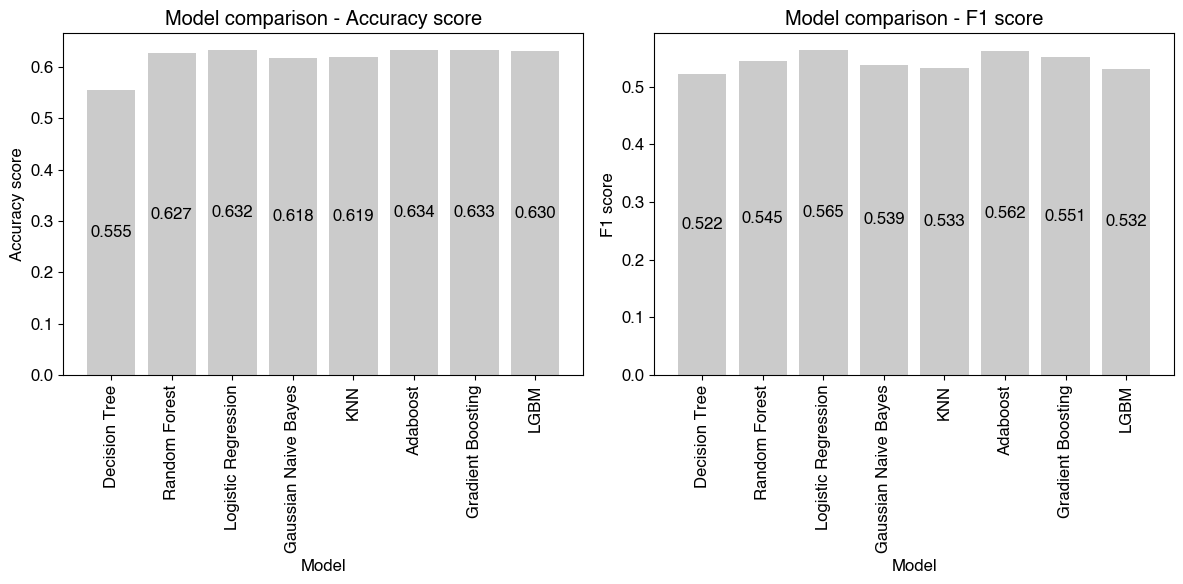

In [38]:
# Set the font to Helvetica with size 12
rcParams['font.family'] = 'Helvetica'
rcParams['font.size'] = 12

# Define the models and scores
model_names = ['Decision Tree', 'Random Forest', 'Logistic Regression', 'Gaussian Naive Bayes', 'KNN', 
               'Adaboost', 'Gradient Boosting', 'LGBM']
accuracy_scores = [decision_tree.score(X_test, y_test), rf.score(X_test, y_test), logistic_regression.score(X_test, y_test), 
          gnb.score(X_test, y_test), k_neighbors.score(X_test, y_test), ada_boost.score(X_test, y_test),
          gradient_boost.score(X_test, y_test), accuracy_lgbm]
f1_scores = [f1_score(y_test, decision_tree.predict(X_test)), f1_score(y_test, rf.predict(X_test)), 
             f1_score(y_test, logistic_regression.predict(X_test)), f1_score(y_test, gnb.predict(X_test)), 
             f1_score(y_test, k_neighbors.predict(X_test)), f1_score(y_test, ada_boost.predict(X_test)), 
             f1_score(y_test, gradient_boost.predict(X_test)), f1_score(y_test, lgbm.predict(X_test))]

# Create a subplot with two columns
fig, ax = plt.subplots(figsize=(12,6), ncols=2)

# Plot the accuracy scores in the first column
ax[0].bar(model_names, accuracy_scores, color='#CBCBCB')
ax[0].set_xlabel('Model')
ax[0].set_ylabel('Accuracy score')
ax[0].set_title('Model comparison - Accuracy score')
for i in range(len(model_names)):
    ax[0].text(i, accuracy_scores[i]/2, '{:.3f}'.format(accuracy_scores[i]), ha='center', va='center')
ax[0].tick_params(axis='x', rotation=90)

# Plot the F1 scores in the second column
ax[1].bar(model_names, f1_scores, color='#CBCBCB')
ax[1].set_xlabel('Model')
ax[1].set_ylabel('F1 score')
ax[1].set_title('Model comparison - F1 score')
for i in range(len(model_names)):
    ax[1].text(i, f1_scores[i]/2, '{:.3f}'.format(f1_scores[i]), ha='center', va='center')
ax[1].tick_params(axis='x', rotation=90)

# Set tight layout
fig.tight_layout()

# Export the figure as PDF
fig.savefig('data/model_scores.pdf', bbox_inches='tight')
